In [1]:
from pathlib import Path
import albumentations
import numpy as np
import pandas as pd
import string
import os

# PyTorch Model
import torch
from torch import nn
from torch.nn import functional as F

from PIL import Image
from PIL import ImageFile

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Configurations
IMG_HEIGHT = 75
IMG_WIDTH = 300
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
class ImageCaptchaModel(nn.Module):
    def __init__(self, num_chars):
        super(ImageCaptchaModel, self).__init__()

        # CNN Layer
        self.conv1 = nn.Conv2d(3, 256, kernel_size=(3,3), padding=(1,1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))

        self.conv2 = nn.Conv2d(256, 128, kernel_size=(3,3), padding=(1,1))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))

        self.conv3 = nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1))
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2,2))

        # RNN Layer Preprocess
        self.linear1 = nn.Linear(576, 128)  # Adjusted the input size here
        self.drop1 = nn.Dropout(0.2)

        # LSTM GRU
        self.gru = nn.GRU(128, 64, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)

        self.linear2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, num_chars+1)


    def forward(self, images, targets=None):
        bs, channel, height, width = images.size()

        x = F.relu(self.conv1(images))
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = F.relu(self.conv3(x))
        x = self.maxpool3(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)
        x = self.linear1(x)
        x = self.drop1(x)

        x, _ = self.gru(x)
        x = self.linear2(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        return x

In [4]:
# Get base directory and model path
MODEL_PATH = "/content/model_new_updated.pth"

# Define all possible characters in the captcha
possible_chars = string.ascii_lowercase + string.digits
char_to_label = {char: index + 1 for index, char in enumerate(possible_chars)}

In [5]:
class CaptchaSolver:
    def __init__(self):
        # Total number of unique characters
        self.num_chars = len(possible_chars)

        # Initialize the model and load the pre-trained weights
        self.model = ImageCaptchaModel(self.num_chars)
        self.model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
        self.model.to(DEVICE)
        self.model.eval()

    # Inner Dataset class to handle image transformations
    class DatasetClassifier:
        def __init__(self, images, resize=None):
            self.images = images
            self.resize = resize
            # Define the augmentations (normalizing the image here)
            self.aug = albumentations.Compose(
                [
                    albumentations.Normalize(always_apply=True)
                ]
            )

        def __len__(self):
            return len(self.images)

        def __getitem__(self, item):
            # Perform transformations on the image
            image = self.images[item]

            if self.resize is not None:
                image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)

            image = np.array(image)
            augmented = self.aug(image=image)
            image = augmented["image"]
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)

            return torch.tensor(image, dtype=torch.float)

    # Method to decode model predictions
    @staticmethod
    def decode_predictions(preds, char_to_label):
        preds = preds.permute(1, 0, 2)
        preds = torch.softmax(preds, 2)
        preds = torch.argmax(preds, 2)
        preds = preds.detach().cpu().numpy()
        cap_preds = []
        # Converting label to char for each prediction
        label_to_char = {v: k for k, v in char_to_label.items()}
        for j in range(preds.shape[0]):
            temp = []
            for k in preds[j, :]:
                k = k - 1
                if k == -1:
                    temp.append("-")
                else:
                    temp.append(label_to_char[k + 1])
            tp = "".join(temp)
            cap_preds.append(tp)
        return cap_preds

    # Method to clean decoded predictions by removing consecutive duplicates and dashes
    @staticmethod
    def clean_decoded_predictions(pred):
        return "".join([c for i, c in enumerate(pred) if c != "-" and (i == 0 or c != pred[i - 1])])

    # Main method to predict captcha from an image byte input
    def predict_captcha(self, image_bytes):
        # Convert bytes to image
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

        # Prepare dataset and dataloader
        eval_dataset = self.DatasetClassifier(images=[image], resize=(IMG_HEIGHT, IMG_WIDTH))
        eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for images in eval_loader:
                images = images.to(DEVICE)
                # Get model predictions
                batch_preds = self.model(images)

        # Decode and clean the predictions
        current_preds = self.decode_predictions(batch_preds, char_to_label)
        preds = "".join([c for c in current_preds[0] if c != '-'])
        preds = self.clean_decoded_predictions(preds)

        return preds

In [8]:
def predict_captcha_from_image(image_bytes):
    # Convert bytes to image
    image = Image.open(BytesIO(image_bytes)).convert("RGB")

    # Prepare dataset and dataloader
    captcha_solver = CaptchaSolver()
    eval_dataset = captcha_solver.DatasetClassifier(images=[image], resize=(IMG_HEIGHT, IMG_WIDTH))
    eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=1, shuffle=False)

    with torch.no_grad():
        for images in eval_loader:
            images = images.to(DEVICE)
            # Get model predictions
            batch_preds = captcha_solver.model(images)

    # Decode and clean the predictions
    current_preds = captcha_solver.decode_predictions(batch_preds, char_to_label)
    preds = "".join([c for c in current_preds[0] if c != '-'])
    preds = captcha_solver.clean_decoded_predictions(preds)

    return preds



Saving 0dr13.jpeg to 0dr13.jpeg
Captcha Prediction: 0dr13


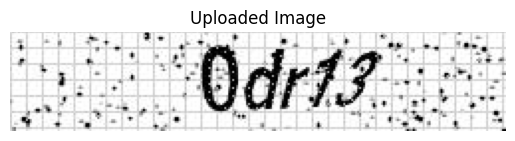

In [10]:
from google.colab import files
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# ...

uploaded = files.upload()

# Call the function with the uploaded image bytes
valid_extensions = ['jpg', 'jpeg', 'png']
image_bytes = None

for filename, content in uploaded.items():
    # Check if the uploaded file has a valid image extension
    if any(filename.lower().endswith(ext) for ext in valid_extensions):
        image_bytes = content
        break

if image_bytes is not None:
    captcha_prediction = predict_captcha_from_image(image_bytes)
    print("Captcha Prediction:", captcha_prediction)

    # Display the uploaded image
    img = Image.open(BytesIO(image_bytes))
    plt.imshow(img)
    plt.title("Uploaded Image")
    plt.axis('off')
    plt.show()
else:
    print("No valid image file found.")
